In [34]:
%matplotlib inline

# Making Rational Protein Design "Intelligent"
### Author: Richard Chen, Jimmy Kim, Stewy Slocum, Jason Wong

## Dependencies

In [35]:
import platform
print(platform.python_version())

2.7.15


In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

np.random.seed(12345)
plt.style.use('seaborn-whitegrid')

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets

## Dataset Loader Class
To handle large datasets with variable mini-batch sizes, I createded a custom dataset loader class. At each epoch, the training set is shuffled. This serves the purpose of reducing variance and making sure that models remain general and overfit less.

In [58]:
class ProteinDatasetLoader(Dataset):
    def __init__(self, X, y):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.X = X
        self.y = y
        self.data_len = X.shape[0]

    def __getitem__(self, index):
        single_featurevec = torch.tensor(self.X[index])
        single_label = self.y[index]

        return (single_featurevec, single_label)

    def __len__(self):
        return self.data_len

## Neural Network Architecture
Code was modified (considerably) from https://github.com/lucas-rosen1/PyTorch_Tutorials/tree/master/Tutorial_1
This implementation uses a 3-layer multilayer perceptron (3 fully connected layers), taking a variable input size, and reducing the feature space to 6 neurons for each layer.

In [74]:
torch.tensor([1,2,3]).squeeze()

tensor([1, 2, 3])

In [63]:
score = nn.MSELoss(reduce=True, reduction='mean')


/Users/richardchen/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [128]:
class NN(nn.Module):    
    def __init__(self, input_size):
        super(NN, self).__init__()
        
        self.net = [
            nn.Linear(input_size, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
        ]
        self.net = nn.Sequential(*self.net)
        
        self.train_loss = []
        self.test_loss = []
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self, pred, true):
        score = nn.MSELoss(reduce=True, reduction='mean')
        return score(pred, true)
    
    def fit(self, train_loader, test_loader, optimizer, num_epoch=10000, print_every=1000):
        
        for epoch in range(num_epoch):
            
            epoch_loss = 0.0
            
            for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                X_batch = Variable(X_batch)
                y_batch = Variable(y_batch)
                
                optimizer.zero_grad()
                y_hat = self.predict(X_batch)
                
                loss = torch.sqrt(self.loss(y_batch, y_hat))
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()
                
            epoch_loss /= batch_idx+1
            
            self.train_loss.append(epoch_loss)
            self.test_loss.append(self.test(test_loader))
            
            
            if epoch % print_every == 0:
                print "Epoch "+str(epoch)+":"
                print "Train Loss:", epoch_loss, "\n"
            
            
    def test(self, test_loader, verbose=False, criterion=nn.MSELoss()):
        self.eval()
        test_loss = 0.0

        with torch.no_grad():
            for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
                X_batch = Variable(X_batch)
                y_batch = Variable(y_batch)
                
                y_hat = self.forward(X_batch).squeeze()
                loss = self.loss(y_hat, y_batch)
                test_loss += loss.item()
        
        test_loss /= batch_idx+1
        
        if verbose:
            print "Test Loss:", test_loss
        
        return test_loss
    
    def predict(self, X):
        return self.forward(X)

## Additional Scripts
Function I wrote that (in order):
1. Use the Protein Dataset Loader class created above to load the data
2. Initialize the network and optimizer
3. Fits the data, printing the training loss and accuracy every 1000 epochs
4. Reports the testing loss and accuracy
5. Returns the model

In [129]:
num_epoch, print_every = 5000, 1000

In [130]:
# Train
data_1BRS = pd.read_table("data/1BRS.matrix.44p.20aa.usingEref_self_digit8.wcsp.data.txt", header=None, delimiter=" ")
data_1CDL = pd.read_table("data/1CDL.matrix.40p.19aa.usingEref_self_digit8.wcsp.data.txt", header=None, delimiter=" ")
data_1ENH = pd.read_table("data/1ENH.matrix.36p.17aa.usingEref_self_digit8.wcsp.data.txt", header=None, delimiter=" ")
data_2DRI = pd.read_table("data/2DRI.matrix.37p.19aa.usingEref_self_digit8.wcsp.data.txt", header=None, delimiter=" ")

# Test
data_1DKT = pd.read_table("data/1DKT.matrix.46p.18aa.usingEref_self_digit8.wcsp.data.txt", header=None, delimiter=" ")

In [136]:
data_train = pd.concat([data_1BRS, data_1CDL, data_1ENH, data_2DRI])
data_test = data_1DKT

w = data_train.shape[1]-1
assert w == data_test.shape[1]-1

X_train, y_train = np.array(data_train[range(w)], dtype=np.float32), np.array(data_train[w], dtype=np.float32)
X_train = preprocessing.scale(X_train)
X_test, y_test = np.array(data_test[range(w)], dtype=np.float32), np.array(data_test[w], dtype=np.float32)
X_test = preprocessing.scale(X_test)


custom_train_loader = ProteinDatasetLoader(X_train, y_train)
custom_test_loader = ProteinDatasetLoader(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset=custom_train_loader,
                                           batch_size=16,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=custom_test_loader,
                                          batch_size=1,
                                          shuffle=False)

In [ ]:
model = NN(input_size=w)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.fit(train_loader, test_loader, optimizer, num_epoch, print_every)
print
model.test(test_loader, verbose=True)

Epoch 0:
Train Loss: 7513.30583753 



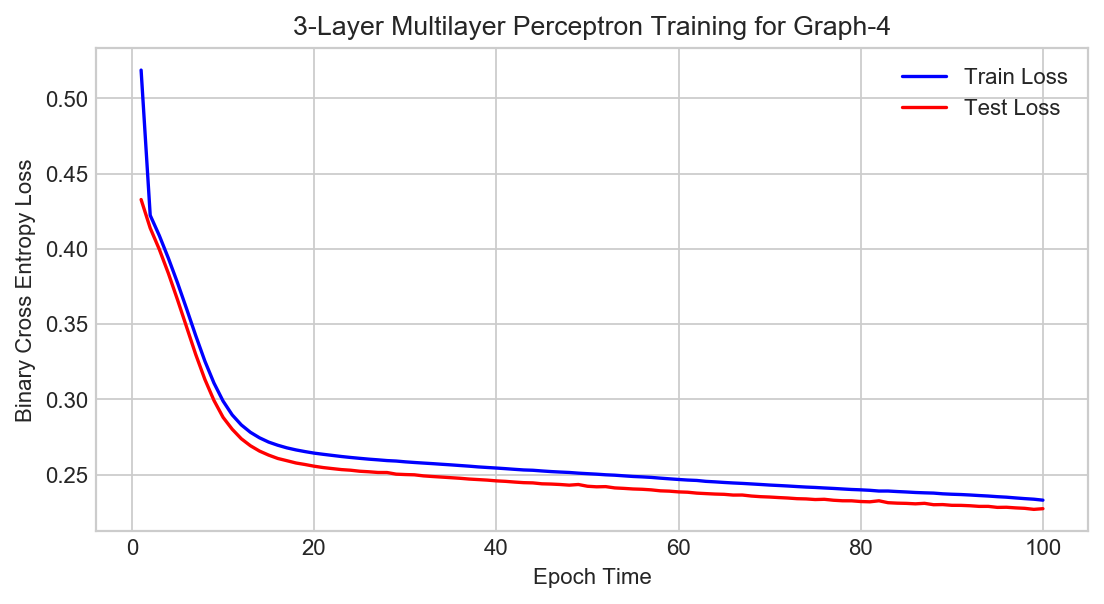

In [28]:
x = np.array(np.linspace(1, num_epoch, num_epoch), int)
fig = plt.figure(figsize=(8, 4), dpi=160)
ax = plt.axes()
plt.title("3-Layer Multilayer Perceptron")
plt.ylabel("Binary Cross Entropy Loss")
plt.xlabel("Epoch Time")
ax.plot(x, model.train_loss, color="blue", label='Train Loss')
ax.plot(x, model.test_loss, color="red", label='Test Loss')
plt.legend()